In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: testROICaT
python version: 3.10.11


In [2]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

In [3]:
# %load_ext autoreload
# %autoreload 2
import roicat

In [4]:
use_classificationResults = False

results_tracking = roicat.helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/ROICaT/ROI_tracking/Nghia/bigRun_20230507/plane_2/NN17/ROICaT.tracking.results.stringency_0.7.pkl')
rundata_tracking = roicat.helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/ROICaT/ROI_tracking/Nghia/bigRun_20230507/plane_2/NN17/ROICaT.tracking.rundata.pkl')

if use_classificationResults:
    results_classification = roicat.helpers.pickle_load(r'/home/rich/Desktop/mouse_0322R.ROICaT.classification_drawn.results.DAY0.pkl')
else:
    results_classification = None


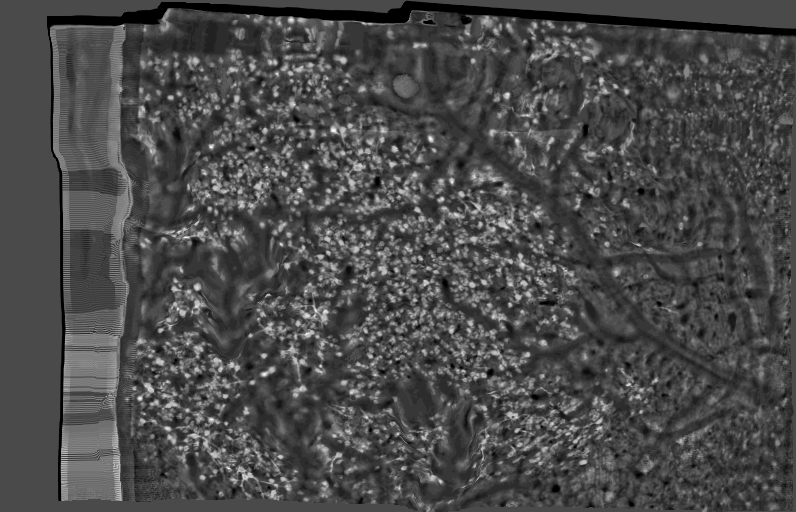

In [5]:
%matplotlib notebook

roicat.visualization.display_toggle_image_stack(rundata_tracking['aligner']['ims_registered_nonrigid'])

<IPython.core.display.Javascript object>


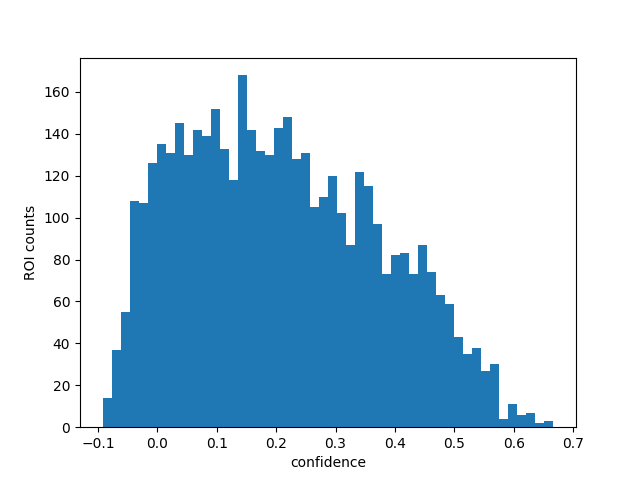

Text(0, 0.5, 'ROI counts')

In [6]:
## Cluster similarity quality metrics
cs_sil         = results_tracking['cluster_quality_metrics']['cs_sil']          ## cluster silhouette score (intra_mean / inter_max)
cs_intra_means = results_tracking['cluster_quality_metrics']['cs_intra_means']  ## mean similarity between all pairwise similarities within each cluster
cs_intra_maxs  = results_tracking['cluster_quality_metrics']['cs_intra_maxs']   ## max similarity between all pairwise similarities within each cluster
cs_intra_mins  = results_tracking['cluster_quality_metrics']['cs_intra_mins']   ## min similarity between all pairwise similarities within each cluster

confidence = (cs_sil * cs_intra_means * cs_intra_mins)

plt.figure()
plt.hist(confidence, 50);
plt.xlabel('confidence');
plt.ylabel('ROI counts')

In [7]:
labels = [c*t - (np.logical_not(c)) for c,t in zip(results_classification['preds'], results_tracking['UCIDs_bySession'])] if use_classificationResults else results_tracking['UCIDs_bySession']

FOVs_colored = roicat.visualization.compute_colored_FOV(
    spatialFootprints=results_tracking['ROIs']['ROIs_aligned'], 
    FOV_height=results_tracking['ROIs']['frame_height'], 
    FOV_width=results_tracking['ROIs']['frame_width'], 
#     labels=results_tracking['UCIDs_bySession'], 
    labels=labels,
#     alphas=confidence / np.percentile(confidence, 90),
    alphas=confidence > 0.2,
)

/media/rich/Home_Linux_partition/github_repos/ROICaT/roicat/visualization.py:249: RuntimeWarning: divide by zero encountered in divide
  rois = rois.multiply(1.2/rois.max(1).A).power(1)



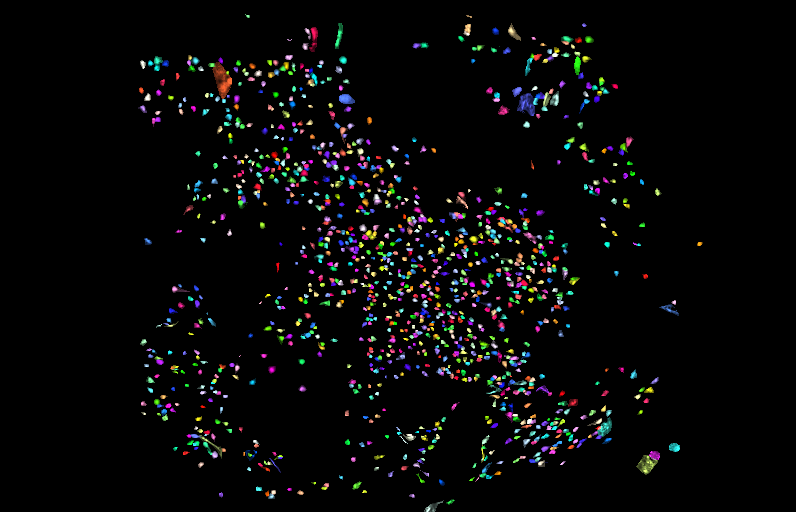

In [8]:
%matplotlib notebook

roicat.visualization.display_toggle_image_stack(FOVs_colored)

/tmp/ipykernel_4100157/1698001595.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


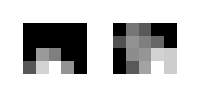

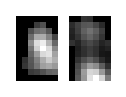

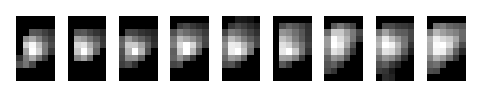

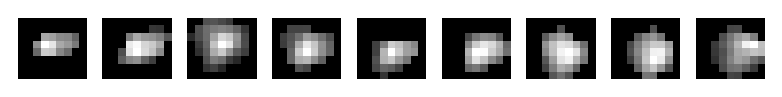

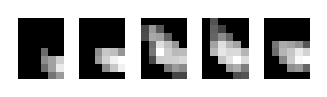

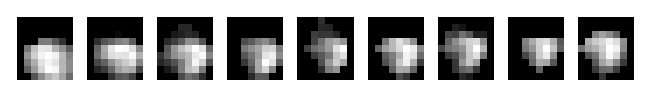

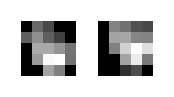

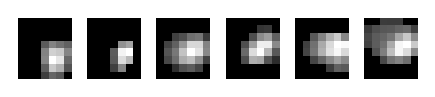

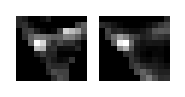

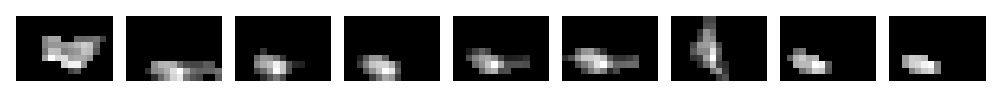

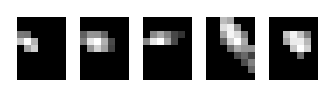

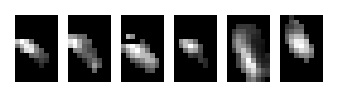

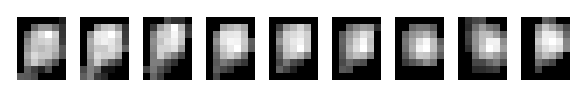

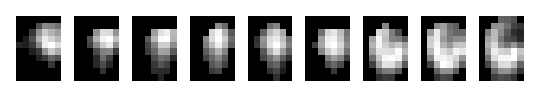

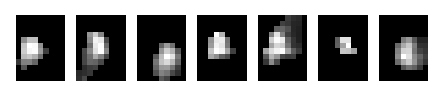

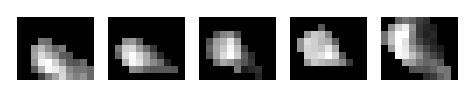

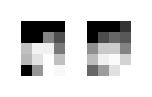

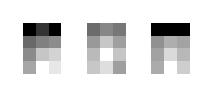

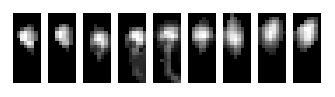

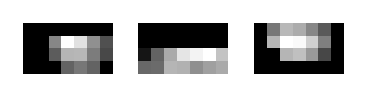

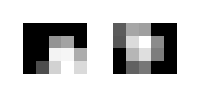

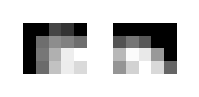

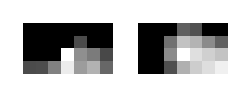

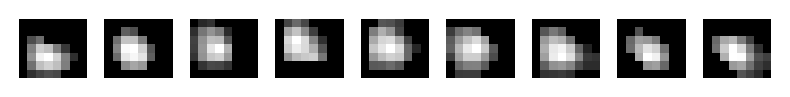

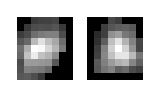

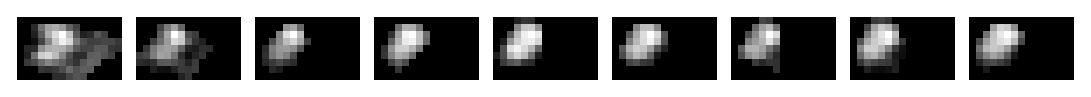

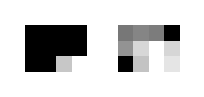

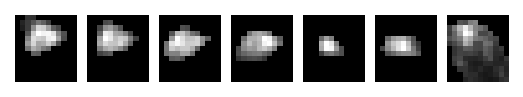

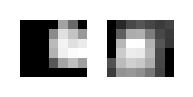

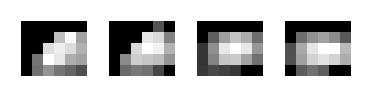

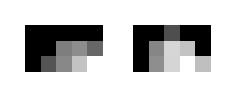

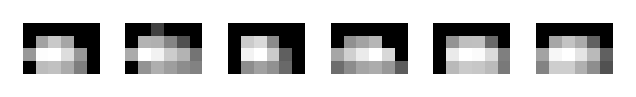

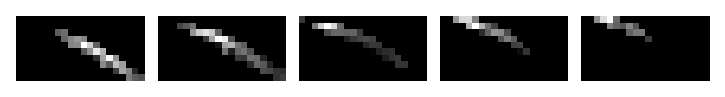

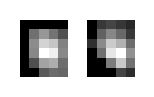

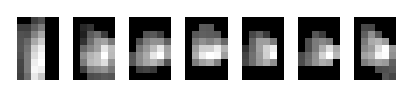

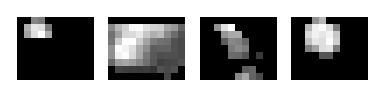

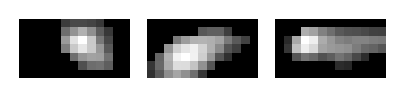

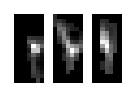

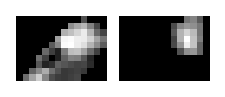

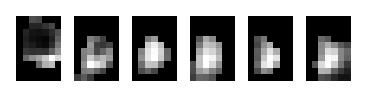

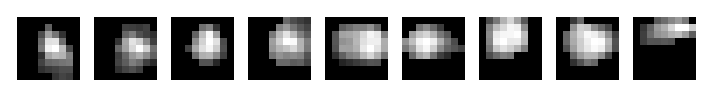

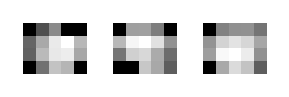

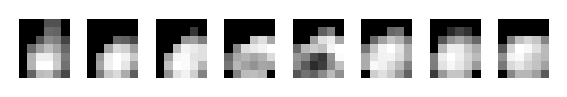

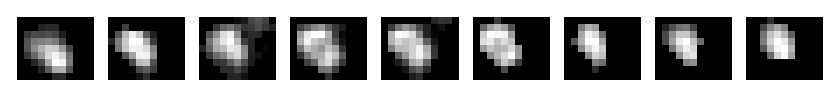

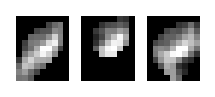

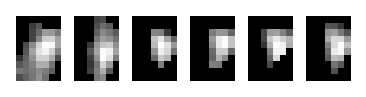

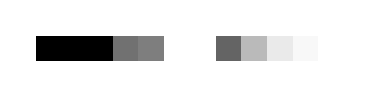

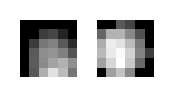

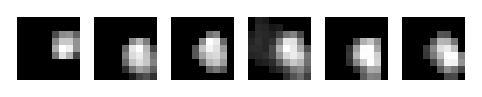

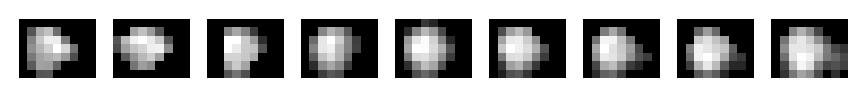

In [9]:
ucids = np.array(results_tracking['UCIDs'])
# ucids = np.concatenate(ucid_gt)
ucids_unique = np.unique(ucids[ucids>=0])

# ROI_ims = np.concatenate(data.ROI_images, axis=0)
ROI_ims_sparse = scipy.sparse.vstack(results_tracking['ROIs']['ROIs_aligned'])
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()


ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), results_tracking['ROIs']['frame_height'], results_tracking['ROIs']['frame_width']))), axis=1) )
#     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
# data.ROI_images[i_sesh][idx] for 


%matplotlib inline

for ii in range(min(len(ucid_sfCat), 50)):
    plt.figure(figsize=(40,1))
    plt.imshow(ucid_sfCat[ii], cmap='gray')
    plt.axis('off')

<IPython.core.display.Javascript object>


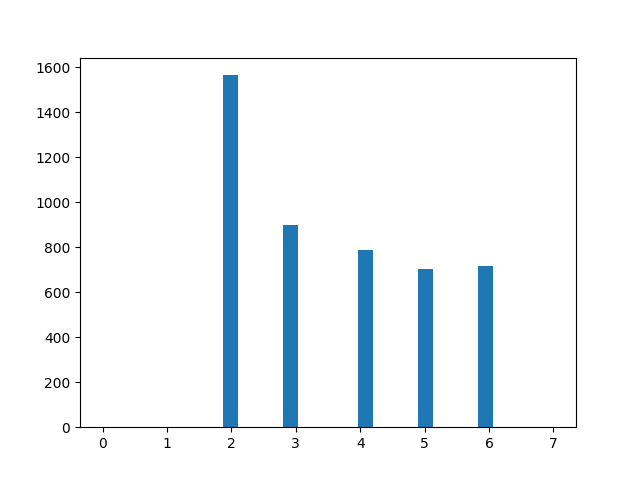

In [71]:
%matplotlib notebook

ucids = np.array(results_tracking['UCIDs'])
_, counts = np.unique(ucids, return_counts=True)

plt.figure()
plt.hist(counts, 30, range=(0, len(results_tracking['UCIDs_bySession'])+1));
